Hi! I'm Katherine Comer, and rising sophomore at the University of Pennsylvania, and here I sough out to discover if there is a relationship between a player's position, how open their shot was, and how likely they were to make their shot.

In [63]:
#import packages
import boto3
import pandas as pd
import numpy as np
from statistics import mean
import math
import seaborn as sns
from sklearn.linear_model import LogisticRegression

In [ ]:
#access nba tracking, event, and player data:
s3_client = boto3.client('s3', 
                         aws_access_key_id=[access_key], 
                         aws_secret_access_key=[secret_access_key])

#download data to folder (pulling from a list of 18 game ids):
game_ids = ["0042100301",
    "0042100302",
    "0042100303",
    "0042100304",
    "0042100305",
    "0042100306",
    "0042100307",
    "0042100311",
    "0042100312",
    "0042100313",
    "0042100314",
    #"0042100315", (will be used to test our logisitical regression formula later)
    "0042100401",
    "0042100402",
    "0042100403",
    "0042100404",
    "0042100405",
    "0042100406"]

for i in range(len(game_ids)):
    #events
    gameid = game_ids[i]
    key = "games/{}/{}_events.jsonl".format(gameid, gameid)
    filename = "{}_events.jsonl".format(gameid)
    s3_client.download_file(Bucket =[bucket], 
                        Key = key, 
                        Filename = filename)
    #tracking
    key = "games/{}/{}_tracking.jsonl".format(gameid, gameid)
    filename = "{}_tracking.jsonl".format(gameid)
    s3_client.download_file(Bucket =[bucket], 
                        Key = key, 
                        Filename = filename)
    
#player
s3_client.download_file(Bucket =[bucket], 
                        Key = [key], 
                        Filename = "players.jsonl")

In [ ]:
#access complimentary nba play by play data (directions provided by WiSD github)
for gameid in game_ids:
    HEADERS = {'Connection': 'keep-alive',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'Referer': 'stats.nba.com',
           'x-nba-stats-origin': 'stats',
           'x-nba-stats-token': 'true',
           'Accept-Language': 'en-US,en;q=0.9',
           "X-NewRelic-ID": "VQECWF5UChAHUlNTBwgBVw==",
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6)' +\
                         ' AppleWebKit/537.36 (KHTML, like Gecko)' + \
                         ' Chrome/81.0.4044.129 Safari/537.36'}

    game_id = gameid
    plays = playbyplay.PlayByPlay(headers=HEADERS,
                              endpoint='playbyplayv2',
                              game_id=game_id)

    play_df = pd.DataFrame(plays.data['PlayByPlay'])

    file_path = f"{game_id}_events.jsonl"

    with open(file_path, 'r') as f:
        json_list = list(f)

    event_list = []
    for json_str in json_list:
        result = json.loads(json_str)
        event_list.append(result)

    event_df = pd.DataFrame(event_list)

    joint_df = event_df.merge(play_df, left_on="pbpId", right_on="EVENTNUM", how="left")
    
    #specific columns were picked out for the purposes of my project
    pbp = joint_df[['gameId', 'eventType', 'shotClock', 'gameClock', 'wallClock', 'period',
       'homePlayers', 'awayPlayers', 'playerId', 'pbpId', 'GAME_ID',
       'EVENTNUM', 'EVENTMSGTYPE', 'EVENTMSGACTIONTYPE', 'PERIOD',
       'WCTIMESTRING', 'PCTIMESTRING', 'HOMEDESCRIPTION', 'NEUTRALDESCRIPTION',
       'VISITORDESCRIPTION', 'SCORE']]
    
    #download pbp data to folder
    pbp.to_json("{}_pbp.jsonl".format(gameid))

I needed to only look at the data surrounding each shot from every game given. I created function that took in a game id, and gathered the location data of the shooter and every defensive player (to find the closest defender to the shooter at the time of the shot), as well as whether or not the shot was made. 

In [84]:
#create a function that takes in a game id
def collect(gameid):
    #0 create data storage:
    
    shots_data = pd.DataFrame({
    'game_id': [],
    'shooter_id': [],
    'shot_time': [],
    'min_dist': [],
    'make=1': []
    })

    #1 load data:
    
    events = pd.read_json("{}_events.jsonl".format(gameid), lines=True)
    track = pd.read_json("{}_tracking.jsonl".format(gameid), lines=True)
    pbp = pd.read_json("{}_pbp.jsonl".format(gameid))
    
    #1b merge dataframes into one:
    
    game = pd.merge(pd.merge(events,track,on='wallClock'),pbp,on='wallClock')
    
    #2 filter to obtain only data about shots:
    
    game_shots = game.loc[game.eventType_x=="SHOT"]
    with pd.option_context('mode.chained_assignment', None): #error supression
        #below to meant to ease working around [None] dataframe cells
        game_shots.HOMEDESCRIPTION.replace(to_replace=[None], value="No Description", inplace=True)
        game_shots.VISITORDESCRIPTION.replace(to_replace=[None], value="No Description", inplace=True)
        #to remove shots with fouls, etc.
        game_shots = game_shots.loc[(game_shots["EVENTMSGTYPE"]==1) | (game_shots["EVENTMSGTYPE"]==2)]
    
    #3 retrieve shooter ids, shot times, and shot locations:
    
    shooter_ids = game_shots.playerId_x
    shot_times = game_shots.wallClock
    shot_locations = track.loc[track.wallClock.isin(shot_times)]
    
    #4 determining openness of shot for each shot in game_shots:
    
    for shot in range(len(game_shots)):
        
    #4a getting shooter's location:
        
        shooter_loc = "NaN"

        while shooter_loc == "NaN":
            for player in range(5):
                if shot_locations["awayPlayers"].iloc[shot][player]['playerId'] == shooter_ids.iloc[shot]:
                    shooter_loc = shot_locations["awayPlayers"].iloc[shot][player]['xyz']
                    shooter_team = "away"
            for player in range(5):
                if shot_locations["homePlayers"].iloc[shot][player]['playerId'] == shooter_ids.iloc[shot]:
                    shooter_loc = shot_locations["homePlayers"].iloc[shot][player]['xyz']
                    shooter_team = "home"
    
    #4b getting defensive player's locations:
        
        defense_loc = []

        if shooter_team == "home":
            for player in range(5):
                defense_loc.append(shot_locations["awayPlayers"].iloc[shot][player]['xyz'])
        if shooter_team == "away":
            for player in range(5):
                defense_loc.append(shot_locations["homePlayers"].iloc[shot][player]['xyz'])
        
    #4c getting min distance between defense and player:
    
        defense_dist = []
        
        for player in range(len(defense_loc)):
            d = defense_loc[player][0:2]
            s = shooter_loc[0:2]
            defense_dist.append(math.dist(d,s))
    
        min_dist = min(defense_dist)
            
    #5 did the player make the shot?
    
        if shooter_team == "home":
            if ("MISS" not in game_shots.HOMEDESCRIPTION.iloc[shot]) == True:
                status = 1
            elif ("MISS" not in game_shots.HOMEDESCRIPTION.iloc[shot]) == False:
                status = 0
        elif shooter_team == "away":
            if ("MISS" not in game_shots.VISITORDESCRIPTION.iloc[shot]) == True:
                status = 1
            elif ("MISS" not in game_shots.VISITORDESCRIPTION.iloc[shot]) == False:
                status = 0
            
    #6 add data to table:
        shots_data.loc[len(shots_data.index)] = [gameid, shooter_ids.iloc[shot], shot_times.iloc[shot], min_dist, status]
    
    #repeat for all shots in game_shots
                            
    return(shots_data)

In [85]:
#example
collect(game_ids[0])

,game_id,shooter_id,shot_time,min_dist,make=1
0,0042100301,561048bb-c412-4d8b-a0bc-27d250a1a431,1652834798699,10.932017,1
1,0042100301,ff41362b-89ef-11e6-babd-a45e60e298d3,1652834818099,4.088643,0
2,0042100301,986b713a-b20b-4eb0-919e-c859d0508af7,1652834835059,4.298930,1
3,0042100301,ff41f5c7-89ef-11e6-8f93-a45e60e298d3,1652834850139,3.671852,0
4,0042100301,a6904c1c-0dc5-41c8-a618-b3a276131726,1652834857499,2.836935,0
...,...,...,...,...,...
154,0042100301,e77c0b40-1652-4d89-8daf-a2f6028938dd,1652844110219,1.655204,0
155,0042100301,ff41f5c7-89ef-11e6-8f93-a45e60e298d3,1652844133579,4.023593,0
156,0042100301,986b713a-b20b-4eb0-919e-c859d0508af7,1652844142099,2.616295,0
157,0042100301,ff41f5c7-89ef-11e6-8f93-a45e60e298d3,1652844150579,2.348829,1


I was unable to find a more efficient way of duplicating this process in a way that could result in a large cumulative dataframe created by the function. So, each dataframe was created and merged manually.

In [88]:
#each game id was ran through the collect() function, and the resulting dataframe was assigned a letter

#conference finals games
a = collect(game_ids[0])
b = collect(game_ids[1])
c = collect(game_ids[2])
d = collect(game_ids[3])
e = collect(game_ids[4])
f = collect(game_ids[5])
g = collect(game_ids[6])
h = collect(game_ids[7])
i = collect(game_ids[8])
j = collect(game_ids[9])
conf_finals = pd.concat([a,b,c,d,e,f,g,h,i,j])

#nba finals games
k = collect(game_ids[10])
l = collect(game_ids[11])
m = collect(game_ids[12])
n = collect(game_ids[13])
o = collect(game_ids[14])
p = collect(game_ids[15])
q = collect(game_ids[16])
nba_finals = pd.concat([k,l,m,n,o,p,q])

#added some identifying columns for ease
conf_finals["round"] = "conference finals"
nba_finals["round"] = "nba finals"

#data was then merged to compiled into one large dataframe
all_data = pd.concat([conf_finals, nba_finals])
#game_id was also turned into a string for stat purposes
all_data["game_id"] = all_data["game_id"].apply(str)

#results
all_data.head()

,game_id,shooter_id,shot_time,min_dist,make=1,round
0,0042100301,561048bb-c412-4d8b-a0bc-27d250a1a431,1652834798699,10.932017,1,conference finals
1,0042100301,ff41362b-89ef-11e6-babd-a45e60e298d3,1652834818099,4.088643,0,conference finals
2,0042100301,986b713a-b20b-4eb0-919e-c859d0508af7,1652834835059,4.298930,1,conference finals
3,0042100301,ff41f5c7-89ef-11e6-8f93-a45e60e298d3,1652834850139,3.671852,0,conference finals
4,0042100301,a6904c1c-0dc5-41c8-a618-b3a276131726,1652834857499,2.836935,0,conference finals


With the data above, I need some player data to compliment it with information about player position, height, etc.

In [89]:
#load in the players data
players = pd.read_json("players.json")

#getting the player id for each shot
shooter_ids = all_data.shooter_id

#creating columns for information needed
all_data["shooter_position"] = "NaN"
all_data["shooter_height"] = "NaN"
all_data["shooter_last"] = "NaN"
all_data["shooter_first"] = "NaN"

#match each shooter id to the appropriate information found in the players dataframe, and add to all_data:
for shooter in range(len(shooter_ids)):
    for row in range(len(players)):
        if (shooter_ids.iloc[shooter] in players.iloc[row,0]["id"]) == True:
            with pd.option_context('mode.chained_assignment', None): #error supression
                all_data["shooter_position"].iloc[shooter] = players.iloc[row,0]["position"]
                all_data["shooter_height"].iloc[shooter] = players.iloc[row,0]["height"]
                all_data["shooter_last"].iloc[shooter] = players.iloc[row,0]["lastName"]
                all_data["shooter_first"].iloc[shooter] = players.iloc[row,0]["firstName"]

#for stat purposes
all_data["shooter_height"] = all_data["shooter_height"].apply(pd.to_numeric)
#results
all_data.head()

,game_id,shooter_id,shot_time,min_dist,make=1,round,shooter_position,shooter_height,shooter_last,shooter_first
0,0042100301,561048bb-c412-4d8b-a0bc-27d250a1a431,1652834798699,10.932017,1,conference finals,F,78.0,Williams,Grant
1,0042100301,ff41362b-89ef-11e6-babd-a45e60e298d3,1652834818099,4.088643,0,conference finals,F,77.0,Tucker,P.J.
2,0042100301,986b713a-b20b-4eb0-919e-c859d0508af7,1652834835059,4.298930,1,conference finals,F-G,80.0,Tatum,Jayson
3,0042100301,ff41f5c7-89ef-11e6-8f93-a45e60e298d3,1652834850139,3.671852,0,conference finals,F,79.0,Butler,Jimmy
4,0042100301,a6904c1c-0dc5-41c8-a618-b3a276131726,1652834857499,2.836935,0,conference finals,G-F,78.0,Brown,Jaylen


Here is whe I began my exploratory data analysis, just to get a general look at any patterns in the data.

In [90]:
all_data.groupby("shooter_position", as_index = False).agg({"min_dist":["mean", "std"], "make=1":["mean"], "shooter_height": ["mean", "std", "max", "min"]})

#forwards are the least closely guarded position, while forward-centers have made the most of their shots.
#guard-esque players made the least of their shots, and were generally guarded from closer than other positions.

shooter_position  min_dist              make=1 shooter_height            \
                        mean       std      mean           mean       std   
0                C  3.908287  2.192573  0.562500      82.375000  0.500000   
1              C-F  4.215862  2.400829  0.602679      81.089286  0.663644   
2                F  5.006217  3.142767  0.466292      78.950843  1.204352   
3              F-C  4.040568  1.770003  0.666667      80.533333  0.915475   
4              F-G  4.045768  1.725674  0.418960      79.724771  0.447314   
5                G  4.808732  2.600492  0.417399      75.385764  1.660141   
6              G-F  4.394252  2.320611  0.410995      77.743455  0.437299   

               
    max   min  
0  83.0  82.0  
1  86.0  81.0  
2  82.0  77.0  
3  82.0  80.0  
4  80.0  79.0  
5  79.0  72.0  
6  78.0  77.0

In [91]:
all_data[["min_dist","shooter_height","make=1"]].corr()

#no strong correlations between these variables.

,min_dist,shooter_height,make=1
min_dist,1.000000,-0.068442,-0.012418
shooter_height,-0.068442,1.000000,0.069340
make=1,-0.012418,0.069340,1.000000


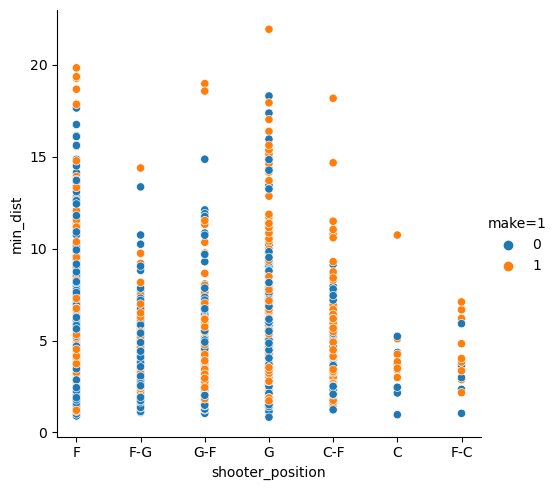

In [92]:
sns.relplot(x="shooter_position", y="min_dist", data=all_data, hue="make=1")

#there seems to be no strong relationship between how close the closest defender was and shooters ability to make the shot,
#for all positions.

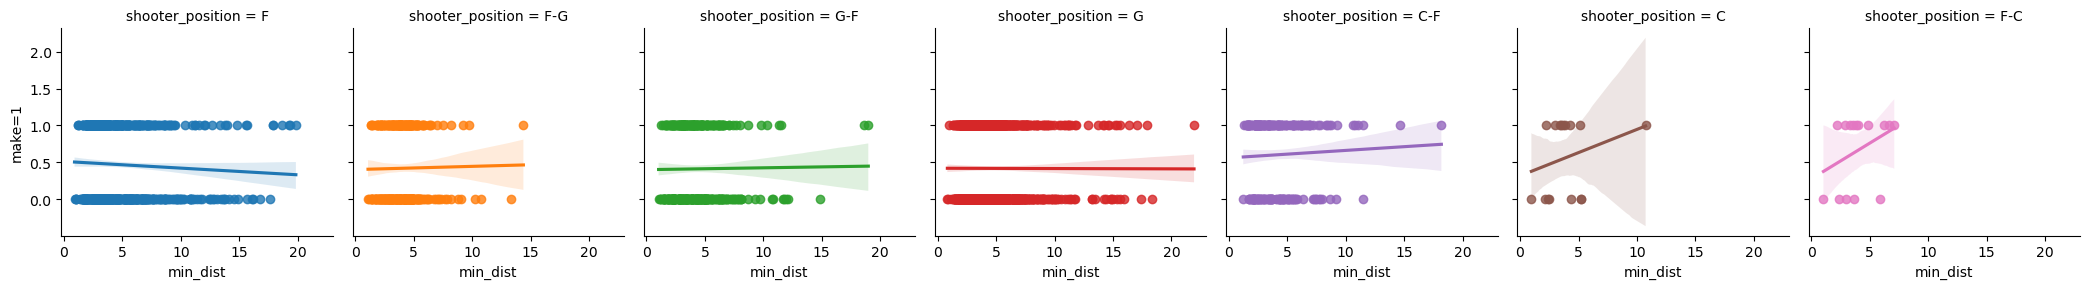

In [93]:
sns.lmplot(x="min_dist", y="make=1", data=all_data, col="shooter_position", hue="shooter_position", height=3)

#Center-forwards, forward-centers, centers are more likely to make their shots when guraded from farther away, 
#while the reverse can be said about true forwards.

Now, I wanted to see how well the distance of the closest defender and the shooters position predicted the likelihood of a shot being made.

In [94]:
#setting my variables
y = all_data[["make=1"]]
X = all_data[["min_dist", "shooter_position"]]
             
#getting dummy varibles for position (a catergorica variable)
X = pd.get_dummies(data=X, drop_first=True)
display(X.head(1))

#setting my model
model = LogisticRegression()

lgrg_model = model.fit(X,y)

print(model.intercept_)
print(model.coef_)

#below are the order of the variables, the model intercept, and the variables coefficients on the last line

,min_dist,shooter_position_C-F,shooter_position_F,shooter_position_F-C,shooter_position_F-G,shooter_position_G,shooter_position_G-F
0,10.932017,0,1,0,0,0,0


[0.11494276]
[[-0.00779707  0.3284053  -0.20991356  0.47140663 -0.40543699 -0.40952369
  -0.43597522]]


C:\Users\katvc\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


To test the accuracy of the model, I gather the same data from game id "0042100315", which was not included in the model, to test against it.

In [96]:
gameid = "0042100315"

test_shots_data = pd.DataFrame({
    'game_id': [],
    'shooter_id': [],
    'shot_time': [],
    'min_dist': [],
    'make=1': []
    })

test_events = pd.read_json("0042100315_events.jsonl", lines=True)
test_track = pd.read_json("0042100315_tracking.jsonl", lines=True)
test_pbp = pd.read_json("0042100315_pbp.jsonl")

#1b merge dataframes into one:
    
test_game = pd.merge(pd.merge(test_events,test_track,on='wallClock'),test_pbp,on='wallClock')

#2 filter to obtain only data about shots:
test_game_shots = test_game.loc[test_game.eventType_x=="SHOT"]
with pd.option_context('mode.chained_assignment', None): #error supression
    #below to meant to ease working around [None] dataframe cells
    test_game_shots.HOMEDESCRIPTION.replace(to_replace=[None], value="No Description", inplace=True)
    test_game_shots.VISITORDESCRIPTION.replace(to_replace=[None], value="No Description", inplace=True)
    test_game_shots = test_game_shots.loc[(test_game_shots["EVENTMSGTYPE"]==1) | (test_game_shots["EVENTMSGTYPE"]==2)]
        
#3 retrieve shooter ids, shot times, and shot locations:
    
test_shooter_ids = test_game_shots.playerId_x
test_shot_times = test_game_shots.wallClock
test_shot_locations = test_track.loc[test_track.wallClock.isin(test_shot_times)]
    
#4 determining openness of shot for each shot in game_shots:
    
for shot in range(len(test_game_shots)):
        
#4a getting shooter's location:
        
    test_shooter_loc = "NaN"

    while test_shooter_loc == "NaN":
        for player in range(5):
            if test_shot_locations["awayPlayers"].iloc[shot][player]['playerId'] == test_shooter_ids.iloc[shot]:
                test_shooter_loc = test_shot_locations["awayPlayers"].iloc[shot][player]['xyz']
                test_shooter_team = "away"
        for player in range(5):
            if test_shot_locations["homePlayers"].iloc[shot][player]['playerId'] == test_shooter_ids.iloc[shot]:
                test_shooter_loc = test_shot_locations["homePlayers"].iloc[shot][player]['xyz']
                test_shooter_team = "home"
    
#4b getting defensive player's locations:
        
    test_defense_loc = []

    if test_shooter_team == "home":
        for player in range(5):
            test_defense_loc.append(test_shot_locations["awayPlayers"].iloc[shot][player]['xyz'])
    if test_shooter_team == "away":
        for player in range(5):
            test_defense_loc.append(test_shot_locations["homePlayers"].iloc[shot][player]['xyz'])
        
#4c getting min distance between defense and player:
    
    test_defense_dist = []
        
    for player in range(len(test_defense_loc)):
        d = test_defense_loc[player][0:2]
        s = test_shooter_loc[0:2]
        test_defense_dist.append(math.dist(d,s))
    
    test_min_dist = min(test_defense_dist)
            
#5 did the player make the shot?
    
    if test_shooter_team == "home":
        if ("MISS" not in test_game_shots.HOMEDESCRIPTION.iloc[shot]) == True:
            status = 1
        elif ("MISS" not in test_game_shots.HOMEDESCRIPTION.iloc[shot]) == False:
            status = 0
    elif test_shooter_team == "away":
        if ("MISS" not in test_game_shots.VISITORDESCRIPTION.iloc[shot]) == True:
            status = 1
        elif ("MISS" not in test_game_shots.VISITORDESCRIPTION.iloc[shot]) == False:
            status = 0
            
    #6 add data to table:
    test_shots_data.loc[len(test_shots_data.index)] = [gameid, shooter_ids.iloc[shot], test_shot_times.iloc[shot], test_min_dist, status]
    
test_shots_data

,game_id,shooter_id,shot_time,min_dist,make=1
0,0042100315,561048bb-c412-4d8b-a0bc-27d250a1a431,1653613441159,2.784547,1
1,0042100315,ff41362b-89ef-11e6-babd-a45e60e298d3,1653613461959,1.905387,0
2,0042100315,986b713a-b20b-4eb0-919e-c859d0508af7,1653613466759,5.556987,1
3,0042100315,ff41f5c7-89ef-11e6-8f93-a45e60e298d3,1653613484919,10.494084,0
4,0042100315,a6904c1c-0dc5-41c8-a618-b3a276131726,1653613490239,1.565439,1
...,...,...,...,...,...
165,0042100315,267de25c-42a5-403a-9fde-0be582ac053b,1653621374559,5.226031,1
166,0042100315,a6904c1c-0dc5-41c8-a618-b3a276131726,1653621455639,4.257347,1
167,0042100315,ff41362b-89ef-11e6-babd-a45e60e298d3,1653621464759,5.590036,0
168,0042100315,ff41f5c7-89ef-11e6-8f93-a45e60e298d3,1653621552999,2.420331,0


In [97]:
test_shots_data["game_id"] = test_shots_data["game_id"].apply(str)

#getting the player id for each shot
shooter_ids = test_shots_data.shooter_id

#creating columns for information needed
test_shots_data["shooter_position"] = "NaN"
test_shots_data["shooter_height"] = "NaN"
test_shots_data["shooter_last"] = "NaN"
test_shots_data["shooter_first"] = "NaN"

#match each shooter id to the appropriate information found in the players dataframe, and add to all_data:
for shooter in range(len(shooter_ids)):
    for row in range(len(players)):
        if (shooter_ids.iloc[shooter] in players.iloc[row,0]["id"]) == True:
            with pd.option_context('mode.chained_assignment', None): #error supression
                test_shots_data["shooter_position"].iloc[shooter] = players.iloc[row,0]["position"]
                test_shots_data["shooter_height"].iloc[shooter] = players.iloc[row,0]["height"]
                test_shots_data["shooter_last"].iloc[shooter] = players.iloc[row,0]["lastName"]
                test_shots_data["shooter_first"].iloc[shooter] = players.iloc[row,0]["firstName"]

#for stat purposes
test_shots_data["shooter_height"] = test_shots_data["shooter_height"].apply(pd.to_numeric)
#results
test_shots_data.head()

,game_id,shooter_id,shot_time,min_dist,make=1,shooter_position,shooter_height,shooter_last,shooter_first
0,0042100315,561048bb-c412-4d8b-a0bc-27d250a1a431,1653613441159,2.784547,1,F,78.0,Williams,Grant
1,0042100315,ff41362b-89ef-11e6-babd-a45e60e298d3,1653613461959,1.905387,0,F,77.0,Tucker,P.J.
2,0042100315,986b713a-b20b-4eb0-919e-c859d0508af7,1653613466759,5.556987,1,F-G,80.0,Tatum,Jayson
3,0042100315,ff41f5c7-89ef-11e6-8f93-a45e60e298d3,1653613484919,10.494084,0,F,79.0,Butler,Jimmy
4,0042100315,a6904c1c-0dc5-41c8-a618-b3a276131726,1653613490239,1.565439,1,G-F,78.0,Brown,Jaylen


Gathering variables, and running the variables through the model for predictions. The predicted values as well as its accuracy was added to the table below.

In [103]:
test_X = pd.get_dummies(data=test_shots_data[["min_dist","shooter_position"]], drop_first=True)
y_pred = model.predict(test_X)
test_shots_data["predicted"] = y_pred
test_shots_data["accurate=true"] = (test_shots_data["predicted"]==test_shots_data["make=1"])
test_shots_data

,game_id,shooter_id,shot_time,min_dist,make=1,shooter_position,shooter_height,shooter_last,shooter_first,predicted,accurate=true
0,0042100315,561048bb-c412-4d8b-a0bc-27d250a1a431,1653613441159,2.784547,1,F,78.0,Williams,Grant,0,False
1,0042100315,ff41362b-89ef-11e6-babd-a45e60e298d3,1653613461959,1.905387,0,F,77.0,Tucker,P.J.,0,True
2,0042100315,986b713a-b20b-4eb0-919e-c859d0508af7,1653613466759,5.556987,1,F-G,80.0,Tatum,Jayson,0,False
3,0042100315,ff41f5c7-89ef-11e6-8f93-a45e60e298d3,1653613484919,10.494084,0,F,79.0,Butler,Jimmy,0,True
4,0042100315,a6904c1c-0dc5-41c8-a618-b3a276131726,1653613490239,1.565439,1,G-F,78.0,Brown,Jaylen,0,False
...,...,...,...,...,...,...,...,...,...,...,...
165,0042100315,267de25c-42a5-403a-9fde-0be582ac053b,1653621374559,5.226031,1,G-F,77.0,Strus,Max,0,False
166,0042100315,a6904c1c-0dc5-41c8-a618-b3a276131726,1653621455639,4.257347,1,G-F,78.0,Brown,Jaylen,0,False
167,0042100315,ff41362b-89ef-11e6-babd-a45e60e298d3,1653621464759,5.590036,0,F,77.0,Tucker,P.J.,0,True
168,0042100315,ff41f5c7-89ef-11e6-8f93-a45e60e298d3,1653621552999,2.420331,0,F,79.0,Butler,Jimmy,0,True


In [119]:
sum(test_shots_data["accurate=true"])/len(test_shots_data)

#this model was accurate less that 50% of the time.

0.49411764705882355

In [126]:
test_shots_data.groupby("shooter_position", as_index = False).agg({"accurate=true":["sum", "count"]})

#similarly, no model was not significantly more successful at predicting the result for any particular position.

shooter_position accurate=true      
                             sum count
0                C             3     5
1              C-F             6    14
2                F            18    37
3              F-C             1     5
4              F-G            12    21
5                G            29    56
6              G-F            15    32

To conclude, it seems that there is no clear relationship between whether or not how open the player is, regardless of position, has a significant impact on how likely they are to make their shot, as shown by the results of our testing data from our train/test split.